# Getting started with Amazon Braket
In this hello-world tutorial we prepare a maximally entangled Bell state between two qubits. We then run our circuit on a local simulator and obtain the results.

In [1]:
# general imports
import matplotlib.pyplot as plt
%matplotlib inline
import string
import time
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

## Build a circuit
Let's build a Bell state with two qubits. By calling Circuit() we create an empty circuit, and we can just add gates to the circuit.

In [2]:
# build a Bell state with two qubits. Here 'cnot(control=0, target=1)' can be simplified as 'cnot(0,1)'
bell = Circuit().h(0).cnot(control=0, target=1)

print(bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


## Submit the circuit to the local simulator and obtain the results
Here we submit our circuit to the local simulator and obtain the results.

In [3]:
# set up device
device = LocalSimulator()

# run circuit
result = device.run(bell, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'00': 500, '11': 500})


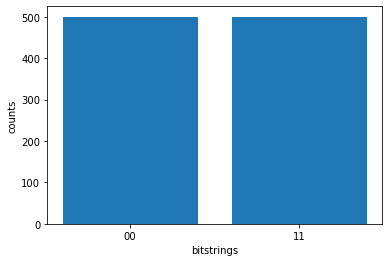

In [4]:
# plot the results
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Running the circuit on a managed simulator
Next, we run our circuit on a managed simulator.
In addition to the local simulator, Amazon Braket offers three managed simulators: a full state-vector simulator SV1,  a tensor-network simulator TN1, and a density-matrix simulator DM1. As shown below, one can seamlessly swap between different devices without any modifications to the circuit definition, by just re-defining the device object.

Running on a managed simulator adds some latency overhead, but is beneficial for larger circuits by leveraging the optimized cloud hardware infrastructure. Moreover, all your results will be stored reliably in S3. Here, as part of the API call with run() you need to supply a S3 location where the metadata and results associated with this circuit execution will be stored.

**NOTE:** Enter your desired device and S3 location (bucket and key) below. If you are working with the local simulator LocalSimulator() you do not need to specify any S3 location. However, if you are using a managed device or any QPU devices you need to specify the S3 location where your results will be stored. Remember that bucket names for Amazon Braket always begin with "amazon-braket-".

In [5]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = # TODO Fill in the name of the bucket
my_prefix = "braket-training" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

Counter({'11': 535, '00': 465})
Counts for all-zero bitstring: 465
Counts for all-one bitstring: 535


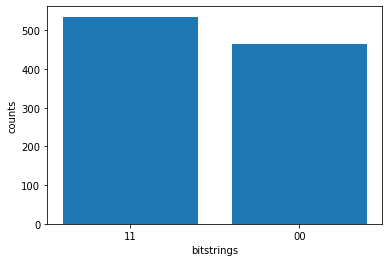

In [6]:
# set up the managed simulator SV1
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

bell = Circuit().h(0).cnot(control=0, target=1)

# run circuit on SV1
result = device.run(bell, s3_folder, shots=1000).result()
counts = result.measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');  

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['00'])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['11'])

Now let's try the TN1 simulator:

Counter({'00': 519, '11': 481})
Counts for all-zero bitstring: 519
Counts for all-one bitstring: 481


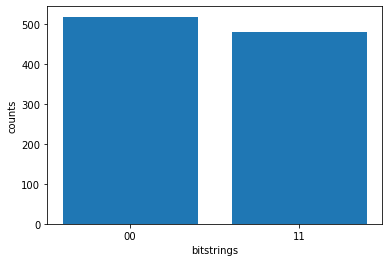

In [7]:
# set up the managed simulator TN1
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/tn1")

bell = Circuit().h(0).cnot(control=0, target=1)

# run circuit on SV1
result = device.run(bell, s3_folder, shots=1000).result()
counts = result.measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');  

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['00'])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['11'])

## Running the circuit on a QPU
Now let's run our circuit on QPU devices. We can run our circuit on both the superconducting machine from Rigetti and the ion-trap machine provided by IonQ. As shown below, one can seamlessly swap between different devices without any modifications to the circuit definition, by just re-defining the device object. We also show how to recover results using the unique ARN associated with every task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution.

### Quantum Hardware: Rigetti
Next we submit our circuit to the superconducting quantum chip provided by Rigetti. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by providing the unique ID associated with every task.

In [8]:
# set up device
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-9")

# create a clean circuit with no result type attached.(This is because some result types are only supported when shots=0)
bell = Circuit().h(0).cnot(0, 1)  

# add the Z \otimes Z expectation value
bell.expectation(Observable.Z() @ Observable.Z(), target=[0,1])

# run circuit 
rigetti_task = rigetti.run(bell, s3_folder, shots=1000)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

Status of task: CREATED


The task is submitted and we can regularly (or irregularly) check the status of this task by executing the following cell. You may easily build logic around this query to wait for this task to complete before your code proceeds.

In [9]:
# print status
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: CREATED


### Quantum Hardware: IonQ
Finally, we submit our example Bell state circuit to IonQ. To this end, we set the device as AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice"). This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task.

In [10]:
# set up device
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# run circuit
ionq_task = ionq.run(bell, s3_folder, shots=1000)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

Status of task: CREATED


In [11]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: CREATED


### Task Recovery
By simply grabbing the unique task ID associated with the quantum tasks we have submitted above, we can recover this task at any point in time and (once the status is completed) visualize and analyze the corresponding results. Note that apart from other metadata, you can retrieve the compiled circuit that was actually run on the Rigetti device. More information about the compiling process can be found [here](https://pyquil-docs.rigetti.com/en/v2.22.0/compiler.html#partial). 

In [12]:
# recover task
task_load = AwsQuantumTask(arn=rigetti_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    rigetti_results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.\n".format(shots, machine))
    
    # get the compiled circuit
    print("The compiled circuit is:\n", rigetti_results.additional_metadata.rigettiMetadata.compiledProgram)
    
    # get measurement counts
    rigetti_counts = rigetti_results.measurement_counts
    print('Measurement counts:', rigetti_counts)

    # plot results: see effects of noise
    plt.bar(rigetti_counts.keys(), rigetti_counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('rigetti.png', dpi=700);
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

Status of (reconstructed) task: QUEUED


Sorry, your task is still being processed and has not been finalized yet.


In [13]:
# recover task
task_load = AwsQuantumTask(arn=ionq_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('bell_ionq.png', dpi=700);
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

Status of (reconstructed) task: CREATED
Sorry, your task is still being processed and has not been finalized yet.


We have successfully recovered the results associated with the tasks that were queued up for the quantum hardware providers. Because of noise (decoherence) and other imperfections we cannot fully recover the exact results we have seen when using the classical simulator. To deal with that, in the fullness of time we will be able to use error correction techniques. As long as error correction is not available, it is important to benchmark our quantum results using classical simulators, whenever possible.

### Supported gate sets by different devices

First, let us check out the gate set currently supported by our SDK. Note that the QPU devices only support a subset of these gates.

In [14]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)
print('\n') 

# the Rigetti device
device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-9")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the Rigetti device:\n', supported_gates)
print('\n') 

# the IonQ device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)

Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CY', 'CZ', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


Gate set supported by the Rigetti device:
 ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z']


Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


### Access to State Vector, Amplitudes, Expectation Values
As opposed to quantum hardware where only measurement shots can be obtained, with a classical simulator you can access the full state vector, amplitudes and expectation values of certain observables by assigning the corresponding result types. To do so, append the result types to the circuit before submitting it to run. This can be very useful for debugging.

In [15]:
device = LocalSimulator()

bell = Circuit().h(0).cnot(control=0, target=1)

bell.state_vector()
# add the Z \otimes Z expectation value
bell.expectation(Observable.Z() @ Observable.Z(), target=[0,1])
# add the amplitude for |11>
bell.amplitude(state=["11"])
# print circuit including requested result types
print(bell)

T  : |0|1|  Result Types  |
                           
q0 : -H-C-Expectation(Z@Z)-
        | |                
q1 : ---X-Expectation(Z@Z)-

T  : |0|1|  Result Types  |

Additional result types: StateVector, Amplitude(11)


In [16]:
# run the circuit and output the results
task = device.run(bell, shots=0)
result = task.result()

# print results
print("Final EXACT state vector:\n", result.values[0])
print("Expectation value <ZZ>:", result.values[1])
print("Amplitude <11|Final state>:", result.values[2])

Final EXACT state vector:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Expectation value <ZZ>: 0.9999999999999998
Amplitude <11|Final state>: {'11': (0.7071067811865475+0j)}


Clearly the expected results with perfect correlations between the three qubits making up the GHZ state are obtained.

Note that you can only request state vector and amplitude when shots = 0 for a classical simulator. When shots = 0 for a simulator, you get the exact values of probability, expectation values, and variance, as derived from the full wave function. When shots > 0, you cannot access the full state vector, but you can get approximate expectation values as taken from measurement samples. Note that Amazon Braket also supports probability, sample, expectation, and variance as result types for QPU devices.